[18:23:55] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Training Accuracy: 0.95
Testing Accuracy: 0.76


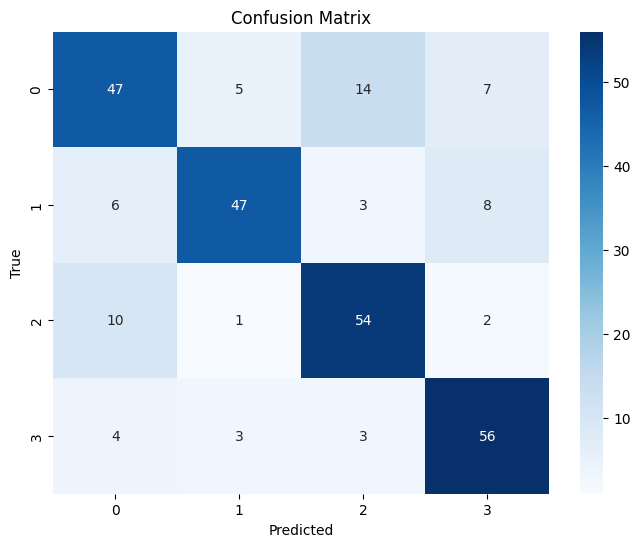

False Negative Rate (FNR) for each class:
Class 0: FNR = 0.36
Class 1: FNR = 0.27
Class 2: FNR = 0.19
Class 3: FNR = 0.15
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        73
           1       0.84      0.73      0.78        64
           2       0.73      0.81      0.77        67
           3       0.77      0.85      0.81        66

    accuracy                           0.76       270
   macro avg       0.76      0.76      0.76       270
weighted avg       0.76      0.76      0.75       270



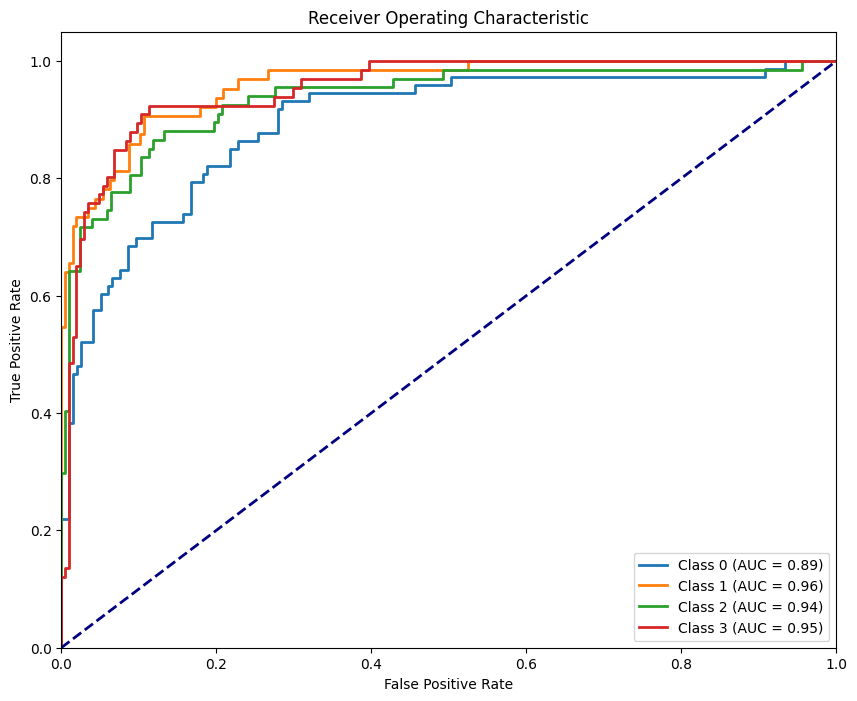

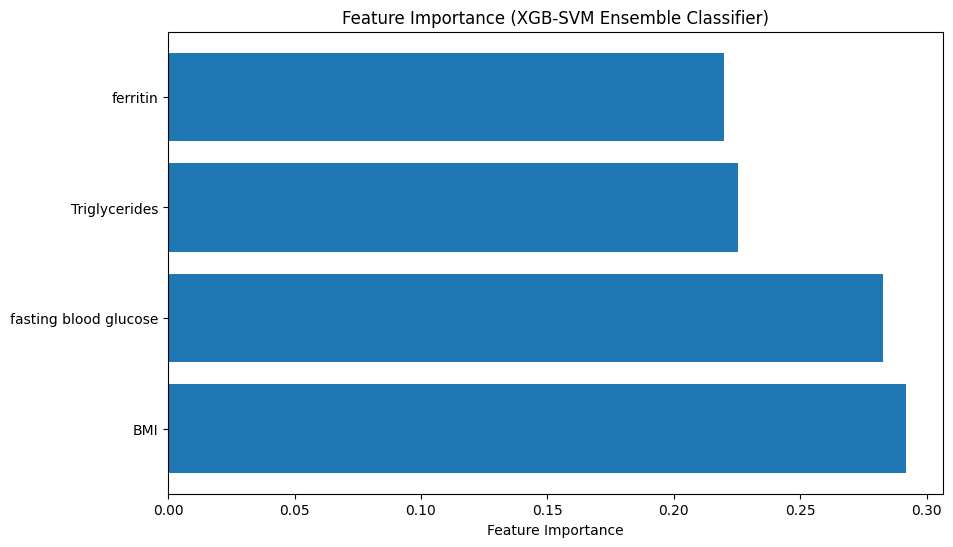

In [1]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load and preprocess training data
data = pd.read_excel('/content/7features_f_4del.xlsx')
data = data.drop(columns=['Creatinine','Alkaline phosphatase','INR','Platelets'])
data.fillna(data.mean(numeric_only=True), inplace=True)

# Load and preprocess external test data
test_data = pd.read_excel('/content/test_7features_f_4del.xlsx')
test_data = test_data.drop(columns=['Creatinine','Alkaline phosphatase','INR','Platelets'])
test_data.fillna(test_data.mean(numeric_only=True), inplace=True)

# Split features and target
X = data.drop('steato score', axis=1)
y = data['steato score']

# Split the internal data into training and 20% test split
X_train, X_internal_test, y_train, y_internal_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine internal test and external test data
X_test_combined = pd.concat([X_internal_test, test_data.drop('steato score', axis=1)], axis=0)
y_test_combined = pd.concat([y_internal_test, test_data['steato score']], axis=0)

# Define base models
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y)),
    learning_rate=0.05,
    max_depth=3,  # Reduced depth to avoid overfitting
    n_estimators=200,
    scale_pos_weight=1,
    eval_metric='mlogloss'
)

svm_model = SVC(probability=True, class_weight='balanced', C=1, gamma=0.01, kernel='rbf')  # Reduced C to avoid overfitting

# Define Voting Classifier
voting_model = VotingClassifier(
    estimators=[('xgb', xgb_model), ('svm', svm_model)],
    voting='soft'
)

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 4],
    'svm__C': [1, 10, 100],
    'svm__gamma': [0.01, 0.1]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(voting_model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the model on the training, testing, and real testing data
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test_combined, y_test_combined)
real_test_acc = best_model.score(test_data.drop('steato score', axis=1), test_data['steato score'])

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Testing Accuracy: {test_acc:.2f}")


# Predict on combined test set
y_pred = best_model.predict(X_test_combined)

# Compute confusion matrix
cm = confusion_matrix(y_test_combined, y_pred)
classes = np.unique(y_test_combined)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute and display FNR for each class
fnr = {}
for i, cls in enumerate(classes):
    FN = cm[i, :].sum() - cm[i, i]  # False negatives for class i
    TP = cm[i, i]  # True positives for class i
    fnr[cls] = FN / (FN + TP) if (FN + TP) != 0 else 0

print("False Negative Rate (FNR) for each class:")
for cls, rate in fnr.items():
    print(f"Class {cls}: FNR = {rate:.2f}")

# Display classification report
print("Classification Report:")
target_names = [str(cls) for cls in classes]
print(classification_report(y_test_combined, y_pred, target_names=target_names))

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve((y_test_combined == cls).astype(int), best_model.predict_proba(X_test_combined)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {cls} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
results = permutation_importance(best_model, X_test_combined, y_test_combined, scoring='accuracy', n_repeats=10, random_state=42)
importance_scores = results.importances_mean
sorted_idx = np.argsort(importance_scores)[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx], importance_scores[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance (XGB-SVM Ensemble Classifier)')
plt.show()


In [4]:
!pip install scikit-learn==1.2.2 xgboost==1.7.6




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 7.2 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
